In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert

import pickle

import sys

sys.path.append("../../../GaussNeuro")
from gaussneuro import utils as utils

import select_units
import tools

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/data/hc3/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load data

In [2]:
# loading data
dataset = 'hc3'
session_id = 'ec014.468'

import preprocess

datadir = "/scratches/ramanujan_2/dl543/hc-3/" + \
    preprocess.sessions_properties[session_id]['rec_id'] + '/' + session_id + '/'

savedir = '/scratches/ramanujan_2/dl543/preprocessed/hc2/'
#savefile = savedir + 

shanks = preprocess.sessions_properties[session_id]['shanks']


ds = preprocess.hc_2_and_3(datadir)
data_dict = ds.load_preprocess_save(None, session_id, shanks)

Less than 2 spikes on channel shank 0 cluster 7, excluded from data.
Less than 2 spikes on channel shank 0 cluster 8, excluded from data.
Less than 2 spikes on channel shank 0 cluster 13, excluded from data.
Less than 2 spikes on channel shank 2 cluster 21, excluded from data.
Less than 2 spikes on channel shank 2 cluster 23, excluded from data.
Less than 2 spikes on channel shank 4 cluster 3, excluded from data.
Less than 2 spikes on channel shank 8 cluster 0, excluded from data.
EEG channels: 99


In [3]:
tbin, timesamples, spktrain, x_t, y_t, hd_t, eeg_t = select_units.load_into_arrays(
    data_dict, -0.014 * np.pi
)  # preprocessed at 1 ms

mean_eeg_t = eeg_t.mean(0)


# hilbert signal of raw
analytic_signal = hilbert(mean_eeg_t)
#hilbert_amp = np.abs(analytic_signal)
hilbert_theta_raw = np.unwrap(np.angle(analytic_signal))

# hilbert signal of filtered
eeg_filt = tools.filter_signal(mean_eeg_t, 5., 11., tbin)

analytic_signal = hilbert(eeg_filt)
#hilbert_amp = np.abs(analytic_signal)
hilbert_theta = np.unwrap(np.angle(analytic_signal))


linear_theta = tools.linear_theta_phase(eeg_filt)

theta_t = hilbert_theta % (2*np.pi)

Total peaks: 63598


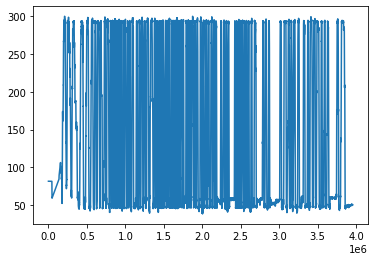

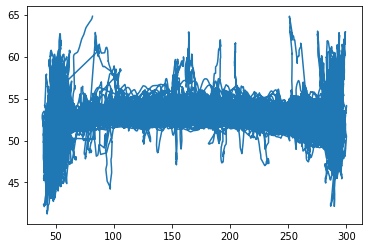

In [8]:
plt.plot(x_t)
plt.show()


plt.plot(x_t, y_t)
plt.show()

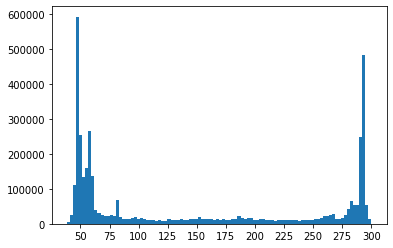

In [7]:
n, bins, _ = plt.hist(x_t, bins=100)
plt.xticks(np.arange(50, 301, 25))
plt.show()

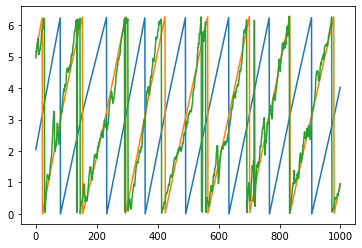

In [8]:
plt.plot(linear_theta[:1000] % (2*np.pi))
plt.plot(hilbert_theta[:1000] % (2*np.pi))
plt.plot(hilbert_theta_raw[:1000] % (2*np.pi))
plt.show()

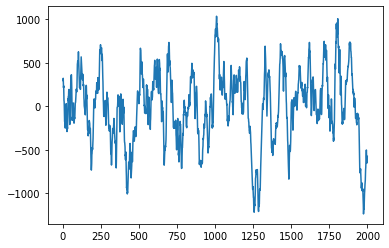

In [9]:
plt.plot(mean_eeg_t[-2000:])
plt.show()

### Theta analysis

In [143]:
# EEG fourier transform
eeg_t_avg = eeg_t.mean(0)

time_steps = eeg_t_avg.shape[0]
timePeriod = sample_bin*time_steps


# FFT of the average EEG signal
fourierTransform = np.fft.rfft(eeg_t_avg)
fourierTransform = fourierTransform[:time_steps//2] # Nyquist upper bound

freq = np.arange(time_steps//2)/timePeriod # in Hz

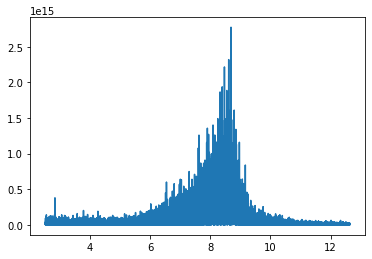

In [144]:
plt.plot(freq[10000:50000], np.abs(fourierTransform[10000:50000])**2)

In [309]:
# Cross-correlograms of spiking activity in population
tbin, resamples, rc_t, behav_t = utils.spikes.bin_data(
    5, sample_bin, spktrain, track_samples, (x_t, y_t, theta_t), average_behav=False, binned=True)

u = 12
cross_correlate = False
correlation = False

cg = utils.spikes.spike_correlogram(rc_t[:u, :], 1, 500, 700000, start_step=10000, ref_point=250, cross=cross_correlate, 
                                    correlation=correlation, dev='cpu')

s = 0
if cross_correlate:
    cg_ = np.zeros((u, u, cg.shape[-1]))
    for u_ in range(u):
        cg_[u_:, u_] = cg[s:s+u-u_]
        s += u-u_

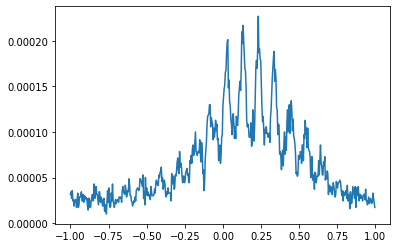

In [187]:
plt.plot(np.arange(-250, 250)*tbin, cg_[11, 9, :])

In [162]:
s = cg
time_steps = s.shape[1]
timePeriod = tbin*time_steps

# FFT of the cg
fourierTransform = np.fft.rfft(s)
fourierTransform = fourierTransform[:time_steps // 2]  # Nyquist upper bound

FP = np.abs(fourierTransform)**2

freq = np.arange(time_steps // 2 + 1e-3) / timePeriod  # in Hz


"""
References:

`Theta-modulated place-by-direction cells in the hippocampal formation in the rat`,
Cacucci, F; Lever, C; Wills, TJ; Burgess, N; O'Keefe, J (2004)

"""
freq_low_limit = 5.
freq_bin = 1./timePeriod

theta_index = np.empty((units))
theta_period = np.empty((units))

border = int(freq_low_limit/freq_bin) # bigger than 5 Hz

theta_period = (np.argmax(FP[:, border:], axis=1) + border)*freq_bin
theta_index = FP[:, border:].max(axis=1)/FP[:, border:].min(axis=1)

0.5
[  5.791718     1.40465058   4.23311271  43.94863411  57.8050747
 143.22540447   1.           1.59413645   3.73976445  11.2560085
   3.47618609  20.03515501]


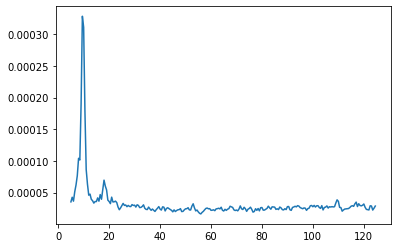

In [156]:
plt.plot(freq[border:250], FP[11, border:250])
print(1/timePeriod)

# significant theta modulation
print(theta_index)

In [253]:
"""
phase precession metric

Instead of time, spikes are now ordered along the theta axis (unwrapped), which warps their 
distances to the theta oscillations time flow. If there is precession, the spikes should be 
most correlated slightly before autocorrelation at 2 pi difference.
"""

u_theta_t = np.unwrap(theta_t) - theta_t[0]
u_theta_s, = utils.spikes.CovariatesAtSpikes(sep_t_spike, (u_theta_t,))
theta_periods = int(u_theta_t.max() / (2*np.pi))+1

bins_per_period = 60
bin_theta = np.linspace(0, theta_periods*2*np.pi, theta_periods*bins_per_period+1)

# phase precession
lag_range = 100
theta_window = len(bin_theta)-1

spikes_theta = np.zeros((units, theta_window))
for u in range(units):
    theta_ind = np.digitize(u_theta_s[u], bin_theta)-1
    np.add.at(spikes_theta[u, :], theta_ind, 1)

u = 12
cg = utils.spikes.spike_correlogram(spikes_theta[:u, :], 1, lag_range, 1800000, start_step=0, ref_point=0, cross=False, 
                                    correlation=False, dev='cpu')

torch.Size([12, 1, 1800000]) torch.Size([12, 100, 1800000])


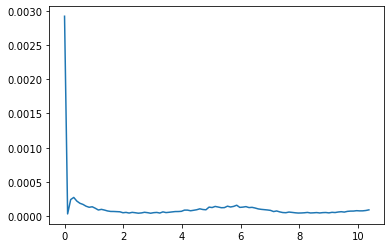

In [254]:
plt.plot(bin_theta[:100], cg[11, :100])

In [255]:
freq_low_limit = 5.
border = int(freq_low_limit/freq_bin) # bigger than 5 Hz

# FFT to get estimate of theta period
fourierTransform = np.fft.rfft2(cg, axes=(1,))
fourierTransform = fourierTransform[:, :int(lag_range/2)] # Nyquist
FP = np.abs(fourierTransform)**2

freq_bin = 1/bins_per_period
freq = np.arange(lag_range//2)*freq_bin

border = bins_per_period//2
relative_precess_freq = (np.argmax(FP[:, border:], axis=1)+border)*freq_bin
precess_index = relative_precess_freq - 1.
precess_amount = np.max(FP[:, border:], axis=1)/np.min(FP[:, border:], axis=1)

In [ ]:
print(precess_index)
print(precess_amount)

### Selecting runs

In [10]:
state_t, state_names = tools.get_L_R_run(x_t, "L-turn")

state_inds = {}
for v in np.unique(state_t):
    state_inds[state_names[v]] = np.where(state_t == v)[0]

# timesamples = len(state_inds[run_type])
# spktrain = spktrain[:, state_inds[run_type]]
# ISIs = ISIs[state_inds[run_type]]
# x_t = x_t[state_inds[run_type]]
# y_t = y_t[state_inds[run_type]]
# hd_t = hd_t[state_inds[run_type]]
# theta_t = theta_t[state_inds[run_type]]

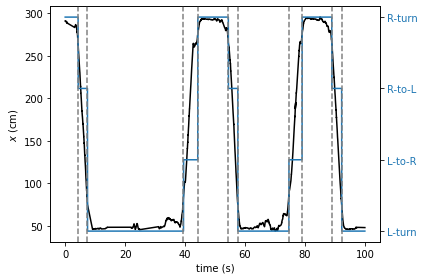

In [11]:
start = 1100000
dur = 100000

fig, ax1 = plt.subplots()

color = 'black'
ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'$x$ (cm)', color=color)
ax1.plot(np.linspace(0, dur*tbin, dur), x_t[start:start+dur], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel(r'Velocity', color=color)  # we already handled the x-label with ax1
ax2.plot(np.linspace(0, dur*tbin, dur), state_t[start:start+dur], color=color)
for point in np.squeeze(np.where(np.diff(state_t[start:start+dur]) != 0)):
    ax2.axvline(point*tbin, ls='--', color='grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.unique(state_t))
ax2.set_yticklabels([state_names[n] for n in np.unique(state_t)])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [50]:
# tracking errors as single points
dx = x_t[1:] - x_t[:-1]
dy = y_t[1:] - y_t[:-1]

for t in range(track_samples-5):
    xx = dx[t:t+4]
    yy = dy[t:t+4]
    
    if np.abs(xx[1]-xx[2]) > (np.abs(xx[0])+np.abs(xx[3]))*2. or np.abs(yy[1]-yy[2]) > (np.abs(yy[0])+np.abs(yy[3]))*2.:
        x_t[t+2] = (x_t[t+1]+x_t[t+3])/2.
        y_t[t+2] = (y_t[t+1]+y_t[t+3])/2.
        print(t)

10305
10316
10325
33672
33683
33697
67605
67612
115833
115846
115859
194470
194490
268825
268832
268835
268838
268841
268844
268851
268854
268857
268863
269856
269877
296938
296941
296946
296949
296952
296957
296960
296968
296971
306790
349455
349470
363548
363560
363575
372703
372706
372714
372719
372724
372727
372732
374502
494717


KeyboardInterrupt: 

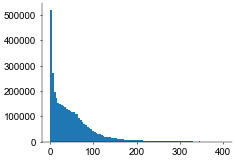

In [57]:
plt.hist(s_t, bins=np.linspace(0, 400, 100))
plt.show()

In [4]:
# regressor correlation
print(stats.corr_lin_lin(x_t, y_t))
print(stats.corr_lin_lin(x_t, s_t))
print(stats.corr_lin_lin(y_t, s_t))

print(stats.corr_circ_circ(dir_t, hd_t))
print(stats.corr_circ_circ(dir_t, theta_t))

print(stats.corr_lin_circ(x_t, theta_t))
print(stats.corr_lin_circ(s_t, theta_t))

0.028386777002903464
0.0592322273078766
0.07958954956762958
-0.15757703608860915
-0.0006284564574182164
1.7018978879653776e-05
0.003943053736834164


In [ ]:
# head direction
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, projection='polar')
#ax.set_rticks([0.04, 0.08, 0.12, 0.16])
ax.set_xlabel('Head angle distribution')
ax.grid(True)
hd_pol = bin_hd[:-1] + delta_bin_hd/2
yy = hd_prob/(bin_hd[1]-bin_hd[0])*np.pi/180.0 # to have integral to one, discrete to density
plt.polar(np.append(hd_pol, hd_pol[0]), np.append(yy, yy[0]), 'r')

# direction
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, projection='polar')
#ax.set_rticks([0.04, 0.08, 0.12, 0.16])
ax.set_xlabel('Movement direction distribution')
ax.grid(True)
dir_pol = bin_dir[:-1] + delta_bin_dir/2
yy = dir_prob/(bin_dir[1]-bin_dir[0])*np.pi/180.0 # to have integral to one, discrete to density
plt.polar(np.append(dir_pol, dir_pol[0]), np.append(yy, yy[0]), 'r')

# speed distribution
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Frequency')
ax.set_xlabel('Speed (mm/s)')
yy = s_prob/delta_bin_s # to have integral to one, discrete to density
ax.set_ylim(0, yy.max()*1.1)
ax.set_xlim(0, max_speed)
ax.plot(bin_s[:-1], yy, color='r')
d = np.zeros(len(s_prob))
ax.fill_between(bin_s[:-1], yy, where=yy>=d, interpolate=True, color='blue')

# position distribution (time spent)
mm = sp_prob.max()
fig, ax = tools.draw_2d(np.transpose(sp_prob), (11,8), origin='lower', aspect='equal', 
           vmax=mm, ticks=[0, mm//4, mm//2, mm*3//4, mm], ticktitle='Probability', 
           ticklabels=['0', str(int(mm//4)), str(int(mm//2)), 
                       str(int(mm*3//4)), '>{}'.format(int(mm))])
# tu.draw_2d(np.transpose(sp_prob), (12,7), origin='lower', xticks=[], yticks=[], aspect='equal', vmax=sp_prob.max()) same

# dot of the pause locations
ax.scatter(x_t[pause_ind]/delta_bin_x, y_t[pause_ind]/delta_bin_y, marker='.', color='r')

plt.show()

In [ ]:
# EEG analysis of theta modulated by speed/pauses
inds = np.where(theta_t[1:] - theta_t[:-1] < 0)[0] # ends of theta cycles
cycle_bins = inds[1:] - inds[:-1]
cycle_s = []
cycle_times = []
for i in range(len(inds[:-1])):
    cycle_s.append(s_t[inds[i]:inds[i]+cycle_bins[i]].mean())
    cycle_times.append(cycle_bins[i]*sample_bin)
    
plt.scatter(cycle_s, cycle_times, s=1)
plt.show()

p = np.argmax(pause_size)
margin = pause_size[p]*3
time = pause_ind[p] + np.arange(pause_size[p]+2*margin) - margin
plt.plot(time[:margin], eeg_t[time[:margin]], color='b')
plt.plot(time[margin:margin+pause_size[p]], eeg_t[time[margin:margin+pause_size[p]]], color='y')
plt.plot(time[margin+pause_size[p]:2*margin+pause_size[p]], eeg_t[time[margin+pause_size[p]:2*margin+pause_size[p]]], color='b')
plt.show()

# check that head angle and movement direction are correlated
plt.figure()
plt.plot(hd_t[0:200], label='movement')
plt.plot(dir_t[0:200], label='head')
plt.xlabel('Timestep')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()

### Compute histograms for tuning

In [4]:
#name = 'L-to-R'

tbin, timesamples, spktrain, x_t, y_t, hd_t, eeg_t = select_units.load_into_arrays(
    data_dict, -0.014 * np.pi
)  # preprocessed at 1 ms

mean_eeg_t = eeg_t.mean(0)


# hilbert signal of raw
analytic_signal = hilbert(mean_eeg_t)
#hilbert_amp = np.abs(analytic_signal)
hilbert_theta_raw = np.unwrap(np.angle(analytic_signal))

# hilbert signal of filtered
eeg_filt = tools.filter_signal(mean_eeg_t, 5., 11., tbin)

analytic_signal = hilbert(eeg_filt)
#hilbert_amp = np.abs(analytic_signal)
hilbert_theta = np.unwrap(np.angle(analytic_signal))


linear_theta = tools.linear_theta_phase(eeg_filt)

theta_t = hilbert_theta % (2*np.pi)


#timesamples = len(state_inds[name])

# spktrain = spktrain[:, state_inds[name]]
# x_t = x_t[state_inds[name]]
# y_t = y_t[state_inds[name]]
# hd_t = hd_t[state_inds[name]]
# theta_t = theta_t[state_inds[name]]

Total peaks: 63598


In [5]:
arena, smth_rate, sp_MI, coherence, sparsity = select_units.histogram_analysis(
    tbin,
    spktrain,
    x_t,
    theta_t,
    min_time_spent=0.025,
    bins_x=40,
    bins_theta=30,
    filter_win_x=31,
    filter_win_theta=31,
    sigma_smooth_x=2,
    sigma_smooth_theta=2,
)

In [14]:
units = spktrain.shape[0]
refract_viol = data_dict["neural"]["refract_viol"]
tot_spikes = spktrain.sum(-1)
Ti = 100000
early_spikes = spktrain[:, :Ti].sum(-1)
print("time bin: ", tbin, " units: ", units)

sel_unit = np.zeros(units).astype(bool)
for u in range(units):
    if coherence[u] > 0.4 and sparsity[u] > 0.6 and refract_viol[u] < 2.0 and \
        tot_spikes[u] > 9e2 and early_spikes[u] > 5:
        sel_unit[u] = True

unit_used = np.where(sel_unit)[0]
print("num of selected cells:", (sel_unit).sum())

time bin:  0.001  units:  96
num of selected cells: 35


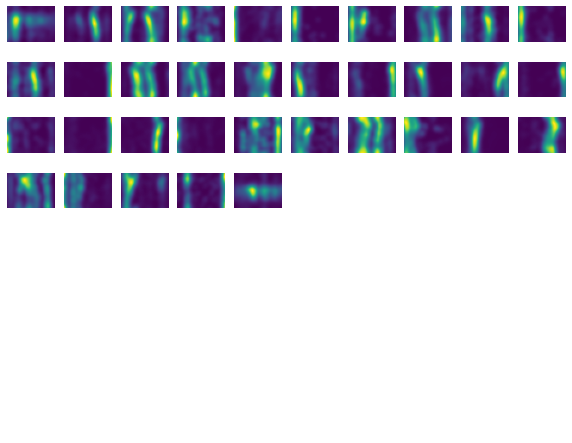

In [15]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')

nrows = 8
ncols = 10
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for nr in range(nrows):
    for nc in range(ncols):
        nnn = nr*ncols + nc
        if nnn >= (sel_unit).sum():
            utils.plots.decorate_ax(axes[nnn], spines=[False, False, False, False])
            continue
        im = axes[nnn].imshow(
            np.transpose(smth_rate[unit_used[nnn]]), origin='lower', aspect='equal', 
            cmap='viridis', vmax=smth_rate[unit_used[nnn]].max(), 
        )
        utils.plots.decorate_ax(axes[nnn], spines=[False, False, False, False])

### Calculating Phase Precession

In [ ]:
# circular regression
def resultant_length(x, y):
    """
    Returns the mean resultant length R of the residual distribution
    """
    return torch.sqrt(torch.mean(torch.cos(x-y))**2 + torch.mean(torch.sin(x-y))**2)



def circ_lin_regression(theta, x, dev='cpu', iters=1000, lr=1e-2):
    """
    Similar to [1].
    
    :param np.array theta: circular input of shape (timesteps,)
    :param np.array x: linear input of shape (timesteps,)
    :param string dev:
    :param int iters: number of optimization iterations
    :param float lr: learning rate of optimization
    
    References:
    
    [1] `Quantifying circular–linear associations: Hippocampal phase precession`,
    Richard Kempter, Christian Leibold, György Buzsáki, Kamran Diba, Robert Schmidt (2012)
    
    """
    #lowest_loss = np.inf
    #shift = Parameter(torch.zeros(1, device=dev))
    a = Parameter(torch.zeros(1, device=dev))

    #optimizer = optim.Adam([a, shift], lr=lr)
    optimizer = optim.Adam([a], lr=lr)
    XX = torch.tensor(x, device=dev)
    HD = torch.tensor(theta, device=dev)

    losses = []
    for k in range(iters):
        optimizer.zero_grad()
        X_ = 2*np.pi*XX*a# + shift
        loss = -1 * resultant_length(X_, HD).mean() # must maximise R
        #loss = (metric(X_, HD, 'torus')**2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())

    a_ = a.cpu().item()
    #shift_ = shift.cpu().item()
    shift_ = np.arctan2(np.sum(np.sin(theta - 2*np.pi*a_*x)),
                        np.sum(np.cos(theta - 2*np.pi*a_*x)))
    
    return 2*np.pi*x*a_ + shift_, a_, shift_, losses

In [ ]:
"""
phase precession metric

Instead of time, spikes are now ordered along the theta axis (unwrapped), which warps their 
distances to the theta oscillations time flow. If there is precession, the spikes should be 
most correlated slightly before autocorrelation at 2 pi difference.
"""

u_theta_t = np.unwrap(theta_t) - theta_t[0]
u_theta_s, = utils.spikes.CovariatesAtSpikes(sep_t_spike, (u_theta_t,))
theta_periods = int(u_theta_t.max() / (2*np.pi))+1

bins_per_period = 60
bin_theta = np.linspace(0, theta_periods*2*np.pi, theta_periods*bins_per_period+1)

# phase precession
lag_range = 100
theta_window = len(bin_theta)-1

spikes_theta = np.zeros((units, theta_window))
for u in range(units):
    theta_ind = np.digitize(u_theta_s[u], bin_theta)-1
    np.add.at(spikes_theta[u, :], theta_ind, 1)

u = 12
cg = utils.spikes.spike_correlogram(spikes_theta[:u, :], 1, lag_range, 1800000, start_step=0, ref_point=0, cross=False, 
                                    correlation=False, dev='cpu')

In [ ]:
freq_low_limit = 5.
border = int(freq_low_limit/freq_bin) # bigger than 5 Hz

# FFT to get estimate of theta period
fourierTransform = np.fft.rfft2(cg, axes=(1,))
fourierTransform = fourierTransform[:, :int(lag_range/2)] # Nyquist
FP = np.abs(fourierTransform)**2

freq_bin = 1/bins_per_period
freq = np.arange(lag_range//2)*freq_bin

border = bins_per_period//2
relative_precess_freq = (np.argmax(FP[:, border:], axis=1)+border)*freq_bin
precess_index = relative_precess_freq - 1.
precess_amount = np.max(FP[:, border:], axis=1)/np.min(FP[:, border:], axis=1)

In [ ]:
print(precess_index)
print(precess_amount)

change
0.09644384682178497 1.0668407771494461


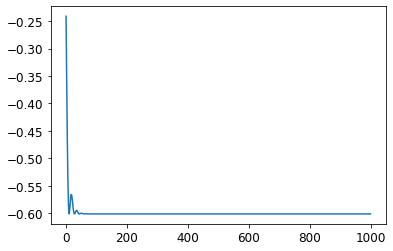

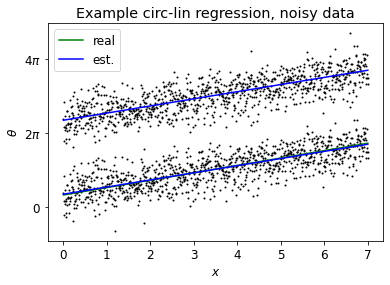

In [30]:
# Try using bivariate Gaussian
x = np.linspace(0, 7, 1000)
ra = 0.1
rshift = 1
theta = (2*np.pi*ra*x + rshift) + np.random.randn(1000)
theta = np.append(theta, theta + 2*np.pi)
x = np.append(x,x)

line, a, shift, losses = utils.latent.circ_lin_regression(theta, x, dev='cpu', iters=1000, lr=1e-2)
print(a, shift)
plt.plot(losses)
plt.show()

fig = plt.figure()
plt.plot(x, theta, 'o', ms=1, c='k')
plt.plot(x, 2*np.pi*ra*x + rshift, 'g', label='real')
plt.plot(x, 2*np.pi*a*x + shift, 'b', label='est.')
plt.plot(x, 2*np.pi*a*x + shift + 2*np.pi, 'b')
plt.title("Example circ-lin regression, noisy data")
plt.ylabel(r'$\theta$')
plt.xlabel(r'$x$')
plt.yticks(ticks=[0,2*np.pi, 4*np.pi], labels=[r'$0$', r'$2\pi$', r'$4\pi$'])
plt.legend()
plt.show()

In [35]:
r_F = np.zeros(20)
r_K = np.zeros(20)
ns = np.logspace(1,6,20)
for i, n in enumerate(ns):
    x = np.linspace(0, 7, int(n/2))
    ra = 0.1
    rshift = 1
    theta = 2*np.pi*ra*x + rshift
    theta = np.append(theta, theta + 2*np.pi)
    x = np.append(x, x)

    line, a, shift, losses = utils.latent.circ_lin_regression(theta, x, dev='cpu', iters=500, lr=1e-2)
#     print(a, shift)
#     plt.plot(losses)

    r_F[i] = utils.stats.corr_lin_circ(x, theta)  # Fisher
    r_K[i] = utils.stats.corr_lin_circ_Kempter(x, theta, a)


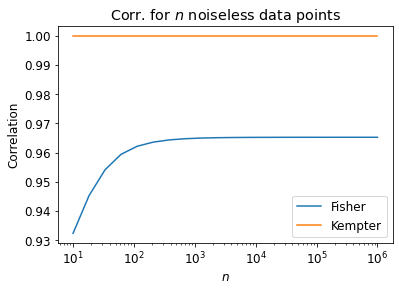

In [33]:
fig = plt.figure()
plt.semilogx(ns, r_F, label='Fisher')
plt.semilogx(ns, r_K, label='Kempter')
plt.title(r'Corr. for $n$ noiseless data points')
plt.ylabel("Correlation")
plt.xlabel(r'$n$')
plt.legend()
plt.show()

In [38]:
c_x_t = utils_func.class_x_t(x_t)
dir_t = utils_func.L_R_run(c_x_t)
ind_L_R = np.where(dir_t == -1)
ind_R_L = np.where(dir_t == 1)
ind_stat = np.where(dir_t == 0)

# incompleted runs:  1


In [39]:
# Taken from analysis-hc3
unit_used = np.array([11, 20, 44, 56, 66, 68], dtype=int)
spktrain_L_R = np.squeeze(spktrain[unit_used][:,ind_L_R])
x_t_L_R = x_t[ind_L_R]
theta_t_L_R = theta_t[ind_L_R]

In [40]:
lims_L_R = {11: [(50, 125)], 20: [(175, 250)], 33: [(50, 125)],
            34: [(125, 275)], 42:[(150, 225), (225, 300)], 43: [(50, 100)],
            44: [(225, 275)], 56: [(200, 275)], 64: [(100, 175), (175, 275)],
            66:[(75, 175), (175, 250)], 68:[(75, 175)], 69: [(175, 275)],
            70:[(75, 150)], 71: [(100, 150)], 79: [(50, 150)], 41:[(0,300)]}

change
change
change
change
change
change
change


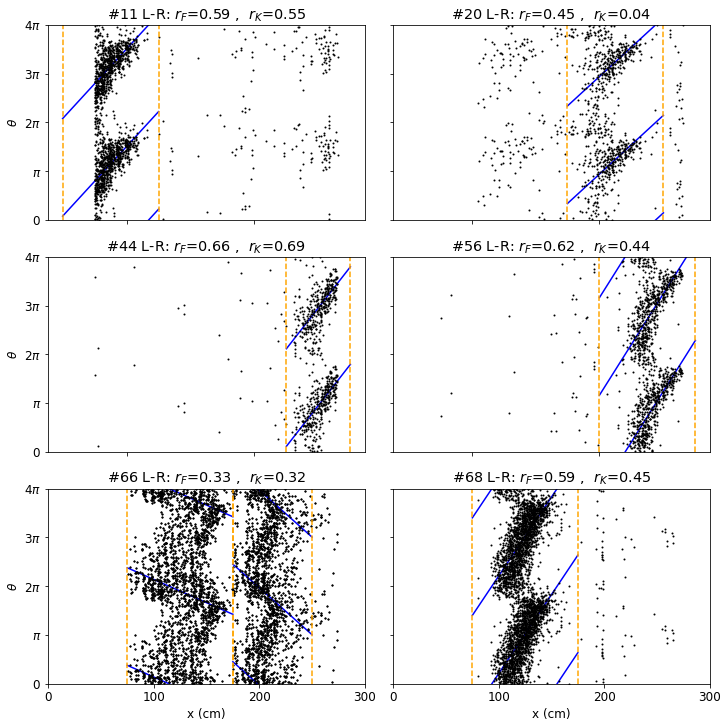

In [42]:
H, W = 3, 2
fig, ax = plt.subplots(H, W, squeeze=True, sharex=True, sharey=True, figsize=(10, 10),constrained_layout=True)

for nn in range(W*H):
    for limit in lims_L_R[unit_used[nn]]:
        all_spikes = spktrain_L_R[nn].astype(bool)
        t_spikes = spktrain_L_R[nn].astype(bool) & (x_t_L_R > limit[0]) & (x_t_L_R < limit[1])
        x = np.linspace(limit[0], limit[1], 1000)
        
        # Find regression line and plot it
        line, a, shift, losses = utils.latent.circ_lin_regression(theta_t_L_R[t_spikes], x_t_L_R[t_spikes], dev='cpu', iters=1000, lr=1e-4)
        [ax[nn // W,nn % W].plot(x, 2*np.pi*x*a + shift + k*2*np.pi, c='b') for k in range(-5,5)]
        
        # Plot spikes
        ax[nn // W,nn % W].plot(x_t_L_R[all_spikes], theta_t_L_R[all_spikes], 'o', ms=1, c='k')
        ax[nn // W,nn % W].plot(x_t_L_R[all_spikes], theta_t_L_R[all_spikes]+2*np.pi, 'o', ms=1, c='k')
        
        # Plot limits
        ax[nn // W,nn % W].axvline(limit[0], ls='--', c='orange')
        ax[nn // W,nn % W].axvline(limit[1], ls='--', c='orange')
        
        r_F = utils.stats.corr_lin_circ(x_t_L_R[t_spikes], theta_t_L_R[t_spikes])
        r_K = utils.stats.corr_lin_circ_Kempter(x_t_L_R[t_spikes], theta_t_L_R[t_spikes], a)
    
    ax[nn // W,nn % W].set_ylim(0,4*np.pi)
    ax[nn // W,nn % W].set_title(r'#{} L-R: $r_F$={:.2f} ,  $r_K$={:.2f}'.format(unit_used[nn], r_F, r_K))

side = np.arange(H)
[ax[s, 0].set_ylabel(r'$\theta$') for s in np.arange(H)]
[ax[s, 0].set_yticks(np.arange(0, 4*np.pi+1e-3, np.pi))  for s in np.arange(H)]
[ax[s, 0].set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])  for s in np.arange(H)]
[ax[2, s].set_xlabel('x (cm)')  for s in np.arange(W)]
[ax[2, s].set_xticks(np.arange(0, 301, 100))  for s in np.arange(W)]

plt.show()

# fig.savefig("output/spikes_corr_regr_6.svg", bbox_inches='tight')